
## MED 5

# Metody ograniczenia wariancji modelu

Poszukując modelu regresji czy klasyfikacji staramy się, by powstały estymator posiadał porządane statystycznie cechy: był zgodny, nieobciążony i najbardziej efektywny. W rzeczywistości trudno jest pogodzić dwie ostatnie własności. Przez brak obciążenia (*ang. bias*) rozumie się bowiem jak najlepsze dopasowanie do danych uczących. Przez największą efektywność rozumie się zwykle jak najmniejszy błąd estymacji dla zbioru testowego (każdego innego niż uczący) - najmniejszą wariancję modelu. Dla rzeczywistych zbiorów danych, na ogół, im mniejsze jest obciążenie, tym jest większa wariancja modelu i odwrotnie. Z uwagi jednak na fakt, iż celem dla którego powstaje model estymatora jest jak najskuteczniejsze jego działanie dla nowych danych (innych niż uczące), przy tworzeniu modelu stosuje się metody, które kosztem zwiększenia obciążenia, zmniejszają wariancję modelu. W praktyce jest to osiągane przez poszukiwanie, w procesie uczenia,  modelu na tyle prostego by właściwie odwzorować trend, niekoniecznie idealnie dopasowującego się do danych zbioru uczącego.  

Zwiększając liczbę cech modelu oraz tworząc nowe zmienne opisujące zwiększa się zwykle jego wariancja. Widać to wyraźnie w przypadku zastosowania regresji wielomianowej. Zwiększanie stopnia wielomianu opisującego trend naszych danych zwiększane zostają współczynniki stojące przy kolejnych potęgach, co pozwala na dokładne dopasowanie modelu do danych uczących, jednak kosztem zwiększenia jego wariancji. Mimo iż obciążenie modelu z punktu widzenia danych uczących spada do zera, to tracimy jego zdolności uogólnienia (błąd estymacji wartości na podstawie zbioru testowego rośnie), co oznacza przeuczenie/nadmierne dopasowanie (ang. overfitting) naszego modelu.

Sposobem na redukcję stopnia przeuczenia/nadmiernego dopasowania modelu, a zatem ograniczenia jego wariancji, w przypadku regresji wielomianowej, są techniki regularyzacji. Generalnie mamy dwie możliwości działania:

1. Redukujemy wpływ cech nieznaczących na model tj. pozostawiamy wszystkie cechy ale w modelu realny wpływ na wyjście mają jedynie cechy znaczące - działa jeśli mamy dużo cech, z których każda skorelowana jest z wyjściem (regularyzacja Tichonowa, regresja grzbietowa - ang. ridge regression).
       
2. Redukujemy liczbę cech na jeden z trzech sposobów:

    a) selekcja manualna - używamy ważniejszych cech (w przypadku unormowanych wartości atrybutów opisujących będą to cechy, przy których wartość modułu współczynnika jest najwyższa)    
    
    b) używamy algorytmu do wyboru cech modelu (metoda zachłanna - analizujemy które cechy najlepiej minimalizują sumę kwadratu błędów)
    
    c) używamy metody regularyzacji eliminującej zbędne cechy (metoda LASSO). 

Regresja grzbietowa i LASSO (Least Absolute Shrinkage and Selection Operator) to efektywne techniki zwykle stosowane do tworzenia oszczędnych modeli w obecności „dużej” liczby funkcji. Tutaj „duże” może zwykle oznaczać jedną z dwóch rzeczy:

1. Wystarczająco duży, aby zwiększyć tendencję modelu do nadmiernego dopasowania (tak niskie, jak 10 zmiennych może powodować nadmierne dopasowanie)
    
2. Wystarczająco duży, aby powodować wyzwania obliczeniowe. W przypadku nowoczesnych systemów taka sytuacja może wystąpić w przypadku milionów lub miliardów cech.

Chociaż metoda grzbietowa i Lasso mogą wydawać się bardzo do siebie  podobne, dzięki specyficznym własnościom ich praktyczne zastosowania różnią się znacznie. Działają one poprzez karanie wielkości współczynników cech oraz minimalizowanie błędu między przewidywanymi a rzeczywistymi obserwacjami. Kluczowa różnica polega na sposobie przypisywania kary do współczynników:

* Regresja grzbietowa (ridge regression, regularyzacja Tichonowa):
        Dokonuje normalizacji L2, tj. Dodaje karę równą kwadratowi wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma kwadratów współczynników)
* Regresja lasso:
        Dokonuje normalizacji L1, tj. Dodaje karę równoważną wartości bezwzględnej wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma wartości bezwzględnych współczynników)

„LS Obj” odnosi się do „celu najmniejszych kwadratów”, tj. Celu regresji liniowej bez regularyzacji.

**Celem tego laboratorium jest zapoznanie się z działaniem metod regularyzacji i dobru cech modelu**.


Materiały pomocnicze, lekkie (wideo) wprowadzenia do:

* [Ridge regression](https://www.youtube.com/watch?v=Q81RR3yKn30)
* [Metody lasso](https://www.youtube.com/watch?v=NGf0voTMlcs)
* [i połączenie obu (elastic net)](https://www.youtube.com/watch?v=1dKRdX9bfIo)

Na początek - wczytanie bibliotek oraz wygenerowanie zbioru danych:

In [1]:
# Wczytaj bilbioteki podstawowe
import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [2]:
# Wczytaj biblioteki potrzebne do zajęć
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

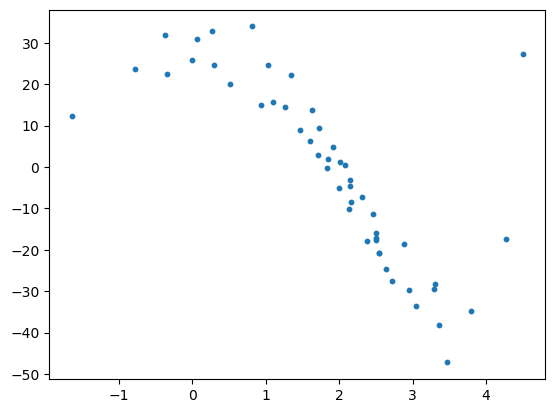

In [3]:
np.random.seed(5)
x = 2 - 3 * np.random.normal(0, 0.5, 50)
y = 30 + x - 5 * (x ** 2) - 2 * (x ** 3)+ 0.15 * (x ** 5)  + np.random.normal(-3, 5, 50)
plt.scatter(x,y, s=10)
plt.show()

### Zadanie 1 - regresja grzbietowa (ridge regression)

Zadanie polega na znalezieniu wielomianu $\hat{f}(x)$ postaci:

$$\hat{f}(x)=\omega_0+\omega_1 x^1+\omega_2x^2+ … +\omega_m x^m,$$

który mimo wysokiej złożoności modelu nie powoduje nadmiernego dopasowania do danych uczących poprzez zastosowanie regularyzacji L2.

Chcemy by nasza funkcja kosztu $J(\omega)$ miała postać:

$$J_{ridge}(\omega)=\sum_{i=0}^{n-1}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^m{\omega^2_j},$$

gdzie $i$ oznacza numer obserwacji, a $j$ kolejność współczynnika.

Wtedy rozwiązanie naszego równania wyzaczającego współczynniki wygląda w następujący sposób:

$$ \omega=\left(X^T X + \lambda \begin{bmatrix}
0 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & \ddots & 0\\ 
0 & 0 & 0  & 1 \\ 
\end{bmatrix}\right) ^{-1} X^Ty $$

**Należy pamiętać, że wyrazu wolnego nie poddajemy regularyzacji !**

A zatem - do dzieła!!!

W ramach pierwszej części zadania należy napisać funkcję wyznaczającą współczynniki $\omega$ wielomianowej funkcji regresji zgodnie z powyższym wzorem.

In [4]:
# Napisz funkcję dopasowującą model regresji wielomianowej z regularyzacją L2 
# (wykorzystując rozwiązanie równania normalnego)
def regresja_L2(X, y, lamb, stopien_wielomianu):
    n = len(X)
    m = stopien_wielomianu

    X_poly = np.zeros((n, m + 1))
    for i in range(m + 1):
        X_poly[:, i] = X ** i

    reg_matrix = np.eye(m + 1)
    reg_matrix[0, 0] = 0

    w = np.dot(
        np.linalg.inv(np.dot(X_poly.T, X_poly) + lamb * reg_matrix),
        np.dot(X_poly.T, y)
    )

    return w



Poprawne (lub nie) działanie powyższej funkcji należy sprawdzić rysując jej wykres na wykresie punktowym zbioru danych

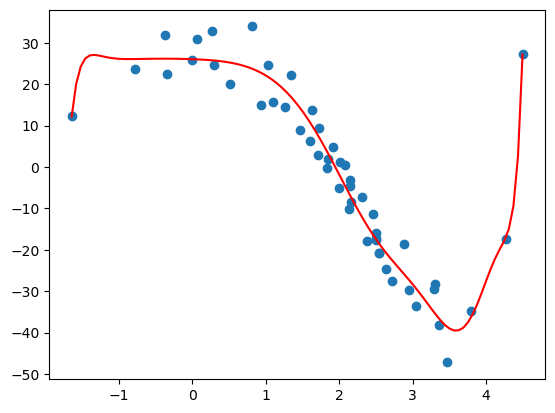

In [5]:
degree = 15
lamb = 10.0
w = regresja_L2(x, y, lamb, degree)
X = np.linspace(min(x), max(x), 100)
X_poly = np.zeros((len(X), degree + 1))
for i in range(degree + 1):
    X_poly[:, i] = X ** i
y_pred = np.dot(X_poly, w)


# Rysowanie wykresu 
plt.scatter(x, y)
plt.plot(X, y_pred, c='red')

Podobnie jak wiele innych metod uczenia maszynowego, także i metoda regresji grzbietowej została zaimplementowana w jednym z pakietów języka Python. W kolejnym kroku należy znaleźć stosowną funkcję oraz porównać wyniki jej działania z własną funkcją.

d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.95671e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


omega_0: reczna=26.056739, Ridge=12.867280
omega_1: reczna=-0.644752, Ridge=1.115853
omega_2: reczna=-1.124403, Ridge=2.462090
omega_3: reczna=-0.915013, Ridge=0.040228
omega_4: reczna=-0.939365, Ridge=0.474452
omega_5: reczna=-0.460219, Ridge=-0.646030
omega_6: reczna=-0.096427, Ridge=-0.222838
omega_7: reczna=0.231194, Ridge=-0.469390
omega_8: reczna=0.200705, Ridge=0.118280
omega_9: reczna=-0.319642, Ridge=0.023073
omega_10: reczna=0.097043, Ridge=0.070838
omega_11: reczna=0.069730, Ridge=0.014419
omega_12: reczna=-0.063660, Ridge=-0.050798

MSE:
Ręczna implementacja: 19.19489203
Ridge: 52.42297401
Różnica MSE: 3.32e+01


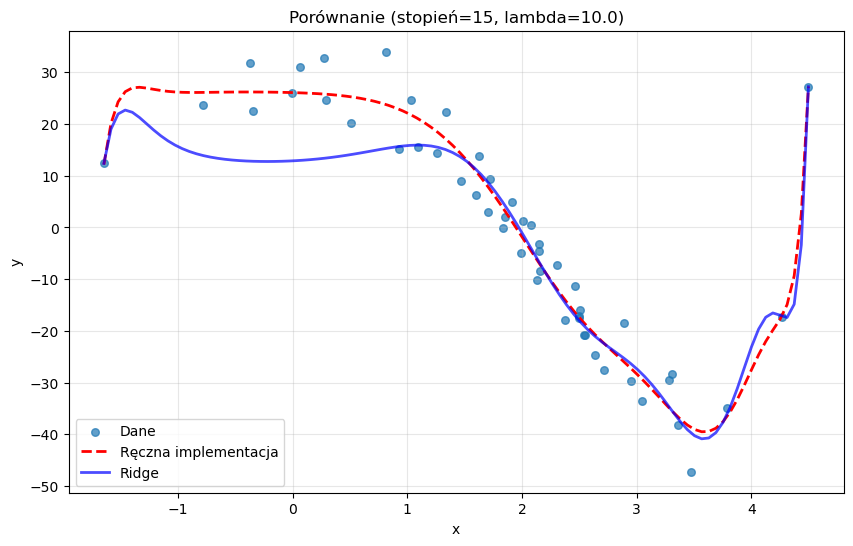

In [6]:
# miejsce na kod
x_plot = np.linspace(x.min(), x.max(), 100)


X_poly = np.column_stack([x**i for i in range(degree + 1)])
X_plot_poly = np.column_stack([x_plot**i for i in range(degree + 1)])


omega_reczna = regresja_L2(x, y, lamb, degree)
omega_reczna = np.asarray(omega_reczna).reshape(-1)


model_ridge = Ridge(alpha=lamb, fit_intercept=False)
model_ridge.fit(X_poly, y)

ridge_coefs = model_ridge.coef_.ravel()
for i in range(min(13, len(omega_reczna))):
    print(f"omega_{i}: reczna={omega_reczna[i]:.6f}, Ridge={ridge_coefs[i]:.6f}")

y_pred_reczna = np.dot(X_poly, omega_reczna)
y_pred_ridge = model_ridge.predict(X_poly)

mse_reczna = np.mean((y - y_pred_reczna)**2)
mse_ridge = np.mean((y - y_pred_ridge)**2)

print(f"\nMSE:")
print(f"Ręczna implementacja: {mse_reczna:.8f}")
print(f"Ridge: {mse_ridge:.8f}")
print(f"Różnica MSE: {abs(mse_reczna - mse_ridge):.2e}")

# Wizualizacja
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Dane', s=30, alpha=0.7)
plt.plot(x_plot, np.dot(X_plot_poly, omega_reczna), c='red', linewidth=2, label='Ręczna implementacja', linestyle='--')
plt.plot(x_plot, model_ridge.predict(X_plot_poly), c='blue', linewidth=2, label='Ridge', alpha=0.7)
plt.xlabel('x'); plt.ylabel('y')
plt.title(f'Porównanie (stopień={degree}, lambda={lamb})')
plt.legend(); plt.grid(alpha=0.3)
plt.show()


Celem wyznaczenia funkcji regresji na całym zbiorze, tak jak to miało miejsce powyżej, było praktyczne sprawdzenie jej działania. W przypadku, gdy uzyskany model estymatora miałby być zastosowany do estymacji wartości wyjściowej dla nieznanych wartości wejściowych (a zwykle tak to właśnie wygląda), oryginalny zbiór danych powinien zostać podzielony na zbiór uczący i testowy.

In [7]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Do oceny modelu w procesie uczenia stosuje się często walidację krzyżową. W omawianym przypadku wyróżnia się dwa parametry metody - stopień wielomianu funkcji regresji oraz parametr $\lambda$. Zwykle pierwszy z nich jest ustalany a-priori, zaś drugi podlega weryfikacji poprzez wykonanie walidacji krzyżowej estymatorów dla różnych jego wartości. 

Korzystając z walidacji krzyżowej (5-krotny wybór zbioru) na zbiorze treningowym napisz funkcję, która dla wielomianu stopnia 15 narysuje wykres średniego błędu uczenia i średniego błędu walidacji, jak również wykres przedstawiający wartości współczynników modelu w funkcji zmiany parametru regularyzacji $\lambda=[0, 0.01, 0.02, 0.04, 0.08, \cdots, 10]$. Można przyjąć, że $\lambda_{a+1}=24\lambda_a$. Można skorzystać z funkcji [cross_validation](https://scikit-learn.org/stable/modules/cross_validation.html) lub [Search_Grid_CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Wartości lambda: [0, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10]


d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.13148e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.477e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.20437e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.07955e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.81824e-19): resul

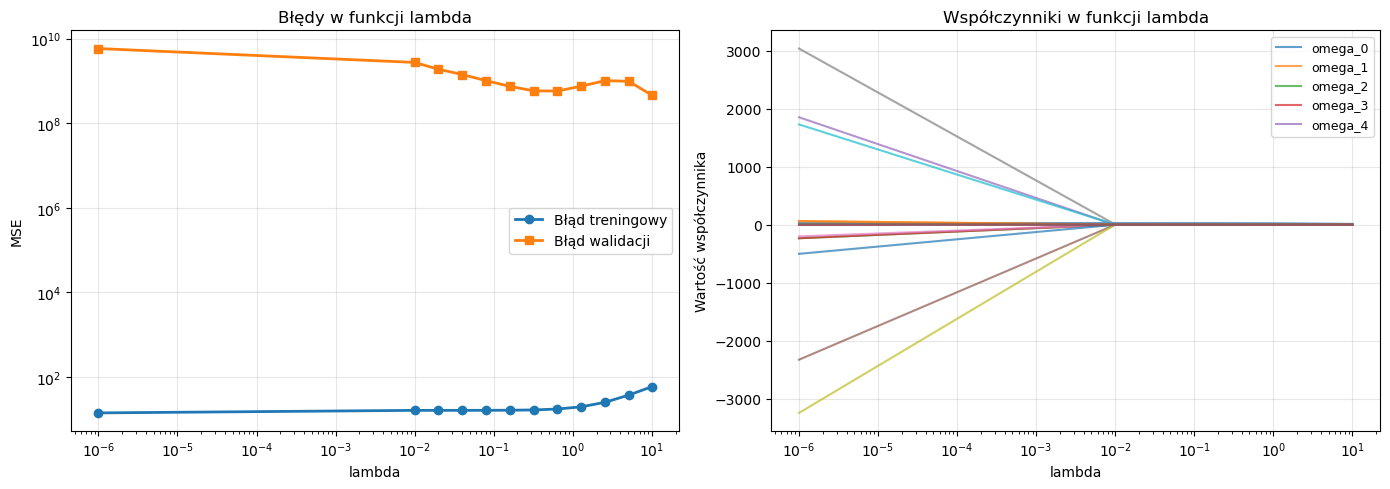


Optymalna wartość lambda: 10.0000
Błąd walidacji dla lambda: 460609271.4198
Błąd treningowy dla lambda: 58.9807
Błąd testowy dla lambda: 9304.7301


d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.15812e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [8]:
# Miejsce na potrzebne funkcje

degree = 15

lambdas = [0]
lambda_current = 0.01
while lambda_current <= 10:
    lambdas.append(round(lambda_current, 8))
    lambda_current *= 2
if 10 not in lambdas:
    lambdas.append(10)

print(f"Wartości lambda: {lambdas}")
X_train_poly = np.column_stack([x_train**i for i in range(degree + 1)])
X_test_poly  = np.column_stack([x_test**i  for i in range(degree + 1)])

train_errors = []
val_errors = []
all_coefficients = []

for lamb in lambdas:
    model = Ridge(alpha=lamb, fit_intercept=False)

    cv_scores = cross_val_score(model, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
    val_error = -cv_scores.mean()
    val_errors.append(val_error)

    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    train_error = np.mean((y_train - y_train_pred)**2)
    train_errors.append(train_error)

    coefs = np.asarray(model.coef_).ravel()
    all_coefficients.append(coefs)

all_coefficients = np.vstack(all_coefficients)  

lambdas_plot = np.array([l if l > 0 else 1e-6 for l in lambdas])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(lambdas_plot, train_errors, 'o-', label='Błąd treningowy', linewidth=2)
plt.plot(lambdas_plot, val_errors, 's-', label='Błąd walidacji', linewidth=2)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('lambda'); plt.ylabel('MSE')
plt.title('Błędy w funkcji lambda')
plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
for i in range(degree + 1):
    label = f'omega_{i}' if i < 5 else None
    plt.plot(lambdas_plot, all_coefficients[:, i], alpha=0.7, label=label)
plt.xscale('log')
plt.xlabel('lambda'); plt.ylabel('Wartość współczynnika')
plt.title('Współczynniki w funkcji lambda')
plt.legend(loc='best', fontsize=9)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

optimal_idx = int(np.argmin(val_errors))
optimal_lambda = lambdas[optimal_idx]
print(f"\nOptymalna wartość lambda: {optimal_lambda:.4f}")
print(f"Błąd walidacji dla lambda: {val_errors[optimal_idx]:.4f}")
print(f"Błąd treningowy dla lambda: {train_errors[optimal_idx]:.4f}")

model_optimal = Ridge(alpha=optimal_lambda, fit_intercept=False)
model_optimal.fit(X_train_poly, y_train)
y_test_pred = model_optimal.predict(X_test_poly)
test_error = np.mean((y_test - y_test_pred)**2)
print(f"Błąd testowy dla lambda: {test_error:.4f}")

**Pytania:**
1. Jak zmieniają się wartości współczynników ze zmianą współczynnika regularyzacji $\lambda$?
2. Która wartość współczynnika regularyzacji $\lambda$ jest najlepsza dla wybranego modelu?

1. Wartości współczynników zbliżają się do siebie

2. Najlepszym współczynnikiem regulacji lambda jest 10, z powodu najmniejszego błędu walidacyjnego.


Wyucz opracowany model (stopnia 15) dla wybranego współczynnik $\lambda$ (uczenie na całym zbiorze treningowym). Wyznacz $\text{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(\hat{f}(x_i)−y_i\right)^2}$ (pierwiastek błędu średniokwadratowego) dla zbioru uczącego i testowego i porównaj z wynikiem otrzymanym dla modelu stopnia 5.  

lamb = 10.0000
Stopień 15: train=7.6799, test=96.4610
Stopień 5: train=8.0989, test=5.9957


d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.15812e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


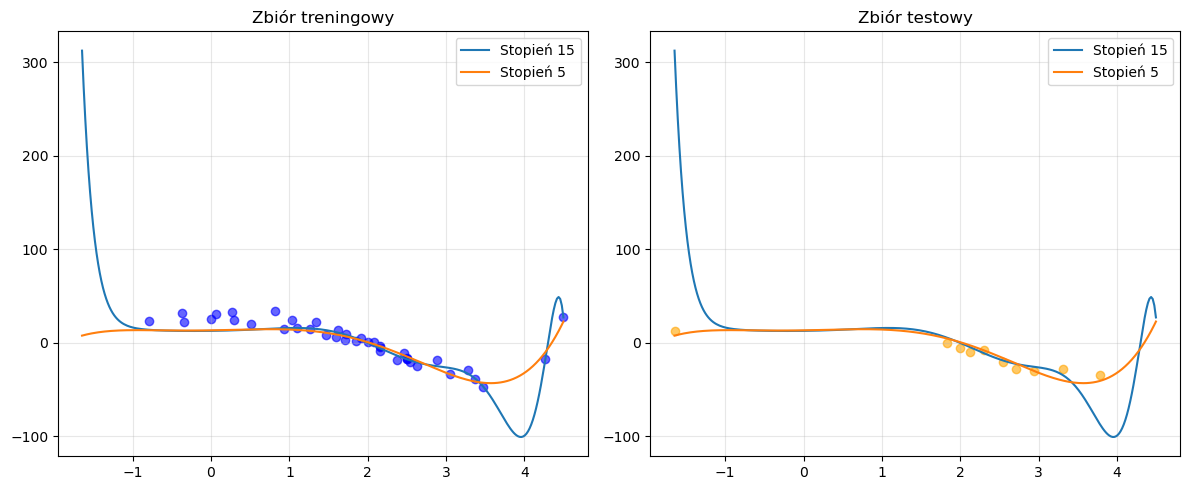

In [9]:
# Miejsce na potrzebne funkcje

lamb = optimal_lambda

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def eval_model(degree, lamb):
    X_tr = np.column_stack([x_train**i for i in range(degree + 1)])
    X_te = np.column_stack([x_test**i for i in range(degree + 1)])
    
    model = Ridge(alpha=lamb, fit_intercept=False)
    model.fit(X_tr, y_train)
    
    return model, rmse(y_train, model.predict(X_tr)), rmse(y_test, model.predict(X_te))

models = {d: eval_model(d, lamb) for d in [15, 5]}

print(f"lamb = {lamb:.4f}")
for d, (m, rm_tr, rm_te) in models.items():
    print(f"Stopień {d}: train={rm_tr:.4f}, test={rm_te:.4f}")

x_plot = np.linspace(x.min(), x.max(), 300)
plt.figure(figsize=(12, 5))

for i, (X_set, y_set, title, color) in enumerate(
    [(x_train, y_train, 'Zbiór treningowy', 'blue'),
     (x_test, y_test, 'Zbiór testowy', 'orange')], 1):
    
    plt.subplot(1, 2, i)
    plt.scatter(X_set, y_set, alpha=0.6, color=color)
    
    for d, (model, _, _) in models.items():
        X_plot_poly = np.column_stack([x_plot**j for j in range(d + 1)])
        plt.plot(x_plot, model.predict(X_plot_poly), label=f'Stopień {d}')
    
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()



### Zadanie 2 - Metoda doboru cech modelu

Pierwszą metodą doboru cech modelu, która zostanie przetestowana jest metoda zachłanna (algorytm w przód). W każdym kroku tej metody poszukujemy cechy, która najlepiej minimalizuje nam średni błąd CV (walidacji krzyżowej), a następnie dodajemy ją do zbioru cech.   

Do tego celu wykorzystamy zbiór przedstawiający ceny mieszkań z King County (do pobrania z ISODu).

In [10]:
# Wczytanie danych
import pandas as pd

dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('MED_Lab_dane/kc_house_data.csv', dtype=dtype_dict)

In [11]:
# Stworzenie nowych zmiennych
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

In [13]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
salesx_train, salesx_test, salesy_train, salesy_test = train_test_split(sales.loc[:, sales.columns != 'price'], sales['price'], test_size=0.2, random_state=0)

Na zbiorze treningowym, dla cech 
['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
przy pomocy walidacji krzyżowej wyznaczamy wykresy błąd modelu, który będzie miał tylko wyraz wolny, a następnie biorąc pojedynczą cechę, a następnie wszystkie podwójne, potrójne itd. cechy wyznaczamy błędy modelu. Na podstawie tych błędów wyznaczamy, które zbiory cech (1, 2, 3, ...) elementowe nalepiej minimalizują nam błąd CV. 

0 cech (RMSE CV = 372483.99)
1 cech (RMSE = 265116.21): ['sqft_living']
2 cech (RMSE = 253526.18): ['sqft_living', 'view']
3 cech (RMSE = 235815.79): ['sqft_living', 'grade', 'yr_built']
4 cech (RMSE = 225202.71): ['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built']
5 cech (RMSE = 216156.01): ['sqft_living', 'sqft_living_sqrt', 'waterfront', 'grade', 'yr_built']
6 cech (RMSE = 214085.61): ['bathrooms', 'sqft_living', 'sqft_living_sqrt', 'waterfront', 'grade', 'yr_built']
7 cech (RMSE = 212337.03): ['bathrooms', 'sqft_living', 'sqft_living_sqrt', 'waterfront', 'view', 'grade', 'yr_built']
8 cech (RMSE = 211489.70): ['bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot_sqrt', 'waterfront', 'view', 'grade', 'yr_built']
9 cech (RMSE = 210992.12): ['bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot_sqrt', 'waterfront', 'view', 'condition', 'grade', 'yr_built']
10 cech (RMSE = 210533.49): ['bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'waterfron

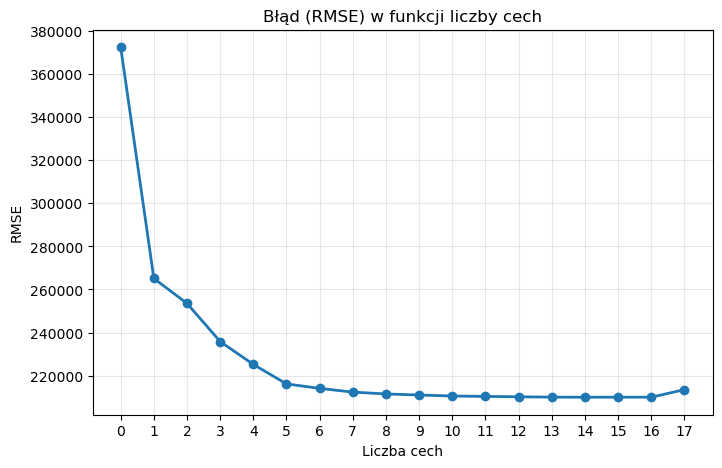


Optymalna liczba cech (z zakresu 0..17): 14
RMSE: 209968.12
Cechy: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated']


In [31]:
from itertools import combinations


features = ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront',
            'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

lr = LinearRegression()
best_results = {}

X_const = np.ones((len(salesy_train), 1))
lr_const = LinearRegression(fit_intercept=False)
scores = cross_val_score(lr_const, X_const, salesy_train, cv=5, scoring='neg_mean_squared_error')
baseline_rmse_cv = np.sqrt(-scores.mean())
best_results[0] = {'features': [], 'rmse': baseline_rmse_cv}
print(f"0 cech (RMSE CV = {baseline_rmse_cv:.2f})")

max_k = len(features)   

for k in range(1, min(max_k, len(features)) + 1):
    best_rmse = np.inf
    best_set = None
    for combo in combinations(features, k):
        X = salesx_train[list(combo)]
        scores = cross_val_score(lr, X, salesy_train, cv=5, scoring='neg_mean_squared_error')
        rmse_val = np.sqrt(-scores.mean())
        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_set = combo
    best_results[k] = {'features': best_set, 'rmse': best_rmse}
    print(f"{k} cech (RMSE = {best_rmse:.2f}): {list(best_set)}")


n_list = sorted(best_results.keys())
rmse_list = [best_results[n]['rmse'] for n in n_list]

plt.figure(figsize=(8,5))
plt.plot(n_list, rmse_list, 'o-', linewidth=2)
plt.xticks(n_list)
plt.xlabel('Liczba cech')
plt.ylabel('RMSE')
plt.title('Błąd (RMSE) w funkcji liczby cech')
plt.grid(alpha=0.3)
plt.show()


opt_n = min(best_results, key=lambda x: best_results[x]['rmse'])
print(f"\nOptymalna liczba cech (z zakresu 0..{min(max_k,len(features))}): {opt_n}")
print(f"RMSE: {best_results[opt_n]['rmse']:.2f}")
print(f"Cechy: {list(best_results[opt_n]['features'])}")


Następnie wykorzystując powyższe wyniki lub opracowując nową funkcję napisz algorytm zachłanny wyboru cech, który do nowego zbioru cech dorzucać będzie cechę, która najlepiej minimalizuje błąd naszego modelu.

Krok | Cecha                 | RMSE_CV
------------------------------------------
   0 | [intercept]                  | 372483.994
   1 | sqft_living                  | 265116.211
   2 | view                         | 253526.184
   3 | sqft_living_sqrt             | 244069.516
   4 | grade                        | 232125.323
   5 | yr_built                     | 219393.227
   6 | waterfront                   | 214338.295
   7 | bathrooms                    | 212337.029
   8 | sqft_lot_sqrt                | 211489.695
   9 | condition                    | 210992.120
  10 | sqft_lot                     | 210533.489
  11 | floors_square                | 210345.848
  12 | floors                       | 210168.706
  13 | bedrooms                     | 210010.767
  14 | yr_renovated                 | 209968.125
  15 | sqft_above                   | 209983.413
  16 | sqft_basement                | 209983.413
  17 | bedrooms_square              | 213462.866


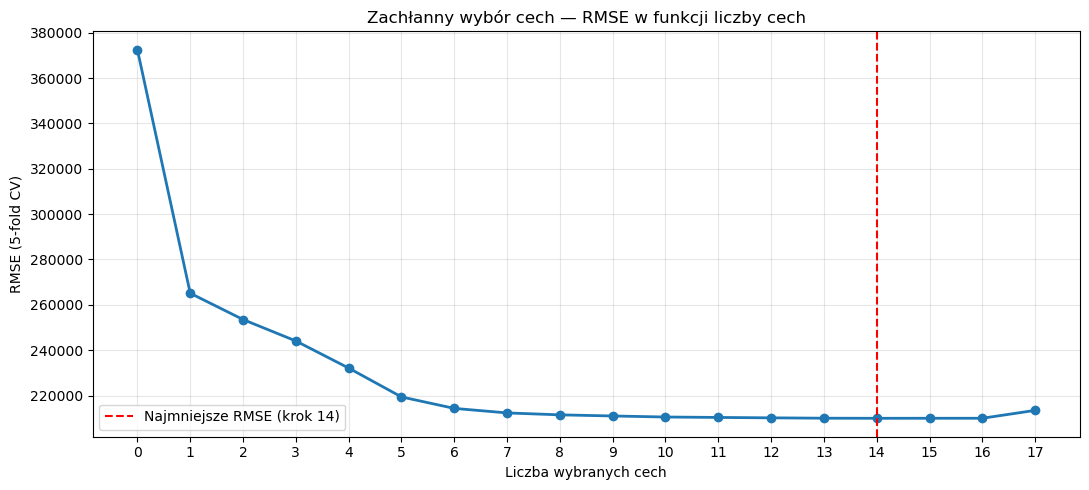



PODSUMOWANIE SELEKCJI
Najlepszy krok: 14
Najmniejszy RMSE: 209968.12
Wybrane cechy (do najlepszego kroku):
  1. sqft_living
  2. view
  3. sqft_living_sqrt
  4. grade
  5. yr_built
  6. waterfront
  7. bathrooms
  8. sqft_lot_sqrt
  9. condition
  10. sqft_lot
  11. floors_square
  12. floors
  13. bedrooms
  14. yr_renovated

Pełna kolejność dodawania cech:
  1. sqft_living
  2. view
  3. sqft_living_sqrt
  4. grade
  5. yr_built
  6. waterfront
  7. bathrooms
  8. sqft_lot_sqrt
  9. condition
  10. sqft_lot
  11. floors_square
  12. floors
  13. bedrooms
  14. yr_renovated
  15. sqft_above
  16. sqft_basement
  17. bedrooms_square


In [ ]:
# Miejce na kod



def greedy_forward(X, y, candidate_feats, folds=5, show=True):
    model = LinearRegression()
    chosen = []
    pool = candidate_feats.copy()
    rmse_history = []

    intercept_X = np.ones((len(X), 1))
    intercept_scores = cross_val_score(model, intercept_X, y, cv=folds, scoring='neg_mean_squared_error')
    intercept_rmse = np.sqrt(-intercept_scores.mean())
    rmse_history.append(intercept_rmse)

    if show:
        print("Krok | Cecha                 | RMSE_CV")
        print("-"*42)
        print(f"{0:>4} | {'[intercept]':<28} | {intercept_rmse:.3f}")

    while pool:
        best_feat = None
        best_rmse = np.inf

        for feat in pool:
            trial = chosen + [feat]
            X_trial = X[trial]
            scores = cross_val_score(model, X_trial, y, cv=folds, scoring='neg_mean_squared_error')
            trial_rmse = np.sqrt(-scores.mean())
            if trial_rmse < best_rmse:
                best_rmse = trial_rmse
                best_feat = feat

        chosen.append(best_feat)
        pool.remove(best_feat)
        rmse_history.append(best_rmse)

        if show:
            step = len(chosen)
            print(f"{step:>4} | {best_feat:<28} | {best_rmse:.3f}")

    return chosen, rmse_history

features = ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view',
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

order, errors = greedy_forward(salesx_train, salesy_train, features, folds=5, show=True)

plt.figure(figsize=(11, 5))
x_vals = list(range(len(errors)))
plt.plot(x_vals, errors, marker='o', linewidth=2)
best_step = int(np.argmin(errors))
plt.axvline(best_step, linestyle='--', color='red', label=f'Najmniejsze RMSE (krok {best_step})')
plt.xticks(x_vals)
plt.xlabel('Liczba wybranych cech')
plt.ylabel('RMSE (5-fold CV)')
plt.title('Zachłanny wybór cech — RMSE w funkcji liczby cech')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\n")
print("PODSUMOWANIE SELEKCJI")

print(f"Najlepszy krok: {best_step}")
print(f"Najmniejszy RMSE: {errors[best_step]:.2f}")
print("Wybrane cechy (do najlepszego kroku):")
if best_step == 0:
    print("tylko intercept")
else:
    for i, f in enumerate(order[:best_step], start=1):
        print(f"  {i}. {f}")

print("\nPełna kolejność dodawania cech:")
for idx, f in enumerate(order, start=1):
    print(f"  {idx}. {f}")


**Prowównaj jak powyżej otrzymane cechy dla algorytmu zachłannego różnią się od najlepszych zbiorów cech.**

In [32]:
candidates = list(features)
regressor = LinearRegression()
picked = []
greedy_summary = {}

while len(picked) < len(candidates):
    current_best_rmse = np.inf
    current_best_feature = None
    for f in candidates:
        if f in picked:
            continue
        trial_feats = picked + [f]
        X_trial = salesx_train[trial_feats]
        neg_mse = cross_val_score(regressor, X_trial, salesy_train, cv=5, scoring='neg_mean_squared_error')
        trial_rmse = np.sqrt(-neg_mse.mean())
        if trial_rmse < current_best_rmse:
            current_best_rmse = trial_rmse
            current_best_feature = f
    picked.append(current_best_feature)
    greedy_summary[len(picked)] = {'features': tuple(picked), 'rmse': current_best_rmse}

print("=== Porównanie zestawów cech ===")
matches = 0
checked = 0

for size in sorted(best_results.keys()):
    forward_set = set(picked[:size]) if size > 0 else set()
    exhaustive_set = set(best_results[size]['features'])
    identical = forward_set == exhaustive_set
    checked += 1
    if identical:
        matches += 1

    header = f"[{size} cech] -> {'TAK' if identical else 'NIE'}"
    print(header)
    print("  Forward-picked :", list(forward_set) if forward_set else [])
    print("  Exhaustive     :", list(exhaustive_set) if exhaustive_set else [])

    if not identical:
        only_fwd = sorted(list(forward_set - exhaustive_set))
        only_exh = sorted(list(exhaustive_set - forward_set))
        if only_fwd:
            print("   + tylko forward   :", only_fwd)
        if only_exh:
            print("   + tylko exhaustive:", only_exh)
    print("-" * 40)

percent = (matches / checked * 100) if checked else 0
print(f"Zgodne zestawy: {matches}/{checked} ({percent:.0f}%)")


=== Porównanie zestawów cech ===
[0 cech] -> TAK
  Forward-picked : []
  Exhaustive     : []
----------------------------------------
[1 cech] -> TAK
  Forward-picked : ['sqft_living']
  Exhaustive     : ['sqft_living']
----------------------------------------
[2 cech] -> TAK
  Forward-picked : ['view', 'sqft_living']
  Exhaustive     : ['view', 'sqft_living']
----------------------------------------
[3 cech] -> NIE
  Forward-picked : ['view', 'sqft_living_sqrt', 'sqft_living']
  Exhaustive     : ['yr_built', 'sqft_living', 'grade']
   + tylko forward   : ['sqft_living_sqrt', 'view']
   + tylko exhaustive: ['grade', 'yr_built']
----------------------------------------
[4 cech] -> NIE
  Forward-picked : ['view', 'sqft_living_sqrt', 'sqft_living', 'grade']
  Exhaustive     : ['sqft_living_sqrt', 'yr_built', 'sqft_living', 'grade']
   + tylko forward   : ['view']
   + tylko exhaustive: ['yr_built']
----------------------------------------
[5 cech] -> NIE
  Forward-picked : ['yr_built', 'g

### Zadanie 3 - Metoda Lasso
W metodzie LASSO (Least Absolute Shrinkage and Selection Operator) wykorzystujemy normę L1 do wygaszenia cech, które nia mają znaczącego wpływu na model. W przypadku tej metody funkcja kosztu C($\omega$) ma następującą postać:

$$C_{lasso}(\omega)=\sum_{i=1}^{n}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^m{|\omega_j|},$$

W przypadku regularyzacji metodą Lasso dokonuje się normalizacji zmiennych opisujących. 

Poniżej przykładowy kod.

In [19]:

from sklearn import linear_model  # using scikit-learn

all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']
model_all = linear_model.Lasso(alpha=5e2) # set parameters
model_all.fit(sales[all_features], sales['price']) # learn weights

d:\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.666e+14, tolerance: 2.913e+11
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=500.0)

**Na podstawie wyników powyższego kodu określ, które cechy zostały wybrane przez algorytm.**

In [20]:
for feature, coef in zip(all_features, model_all.coef_):
    print(f"{feature:20s}  {coef:.4f}")

selected_features = [
    feature for feature, coef in zip(all_features, model_all.coef_)
    if coef != 0
]
print(f"Cechy wybrane przez algorytm: {len(selected_features)} / {len(all_features)}")

bedrooms              -17017.2224
bedrooms_square       337.9218
bathrooms             47497.8224
sqft_living           298.5212
sqft_living_sqrt      -44608.7288
sqft_lot              0.6602
sqft_lot_sqrt         -649.3537
floors                -3532.3175
floors_square         7264.4232
waterfront            487334.6894
view                  43696.5613
condition             26918.7433
grade                 130110.9787
sqft_above            312.2793
sqft_basement         318.8707
yr_built              -3157.2600
yr_renovated          18.9551
Cechy wybrane przez algorytm: 17 / 17


Tak samo jak działaliśmy w przypadku regularyzacji grzbietowej, wydziel 20% zbiór testowy, a następnie przy pomocy CV na zbiorze zbiorze uczącym i powyższego kodu, dokonaj doboru współczynnika alpha. Wykreś RMSE oraz współczynniki poszczególnych cech w funkcji zmiany parametru $\lambda$.

d:\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e+14, tolerance: 1.779e+11
  model = cd_fast.enet_coordinate_descent(
d:\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.394e+14, tolerance: 2.004e+11
  model = cd_fast.enet_coordinate_descent(
d:\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.267e+14, tolerance: 1.866e+11
  model = cd_fast.enet_coo

Optymalne alpha: 868.511373751352
Współczynniki przy dobranym alpha:
bedrooms: -13391.162869813877
bedrooms_square: 189.91531120886762
bathrooms: 43789.272422153
sqft_living: 311.014874421978
sqft_living_sqrt: -45176.558151706224
sqft_lot: 0.6901462627939163
sqft_lot_sqrt: -669.3615775295615
floors: -0.0
floors_square: 6607.288091166248
waterfront: 454683.6239171381
view: 45256.89763557474
condition: 26892.730857823834
grade: 128017.70029688116
sqft_above: 309.8230093312282
sqft_basement: 316.6137164745418
yr_built: -3129.0675341515716
yr_renovated: 20.089345654617816
Liczba cech z niezerowym współczynnikiem: 16
Liczba cech wyzerowanych przez LASSO: 1


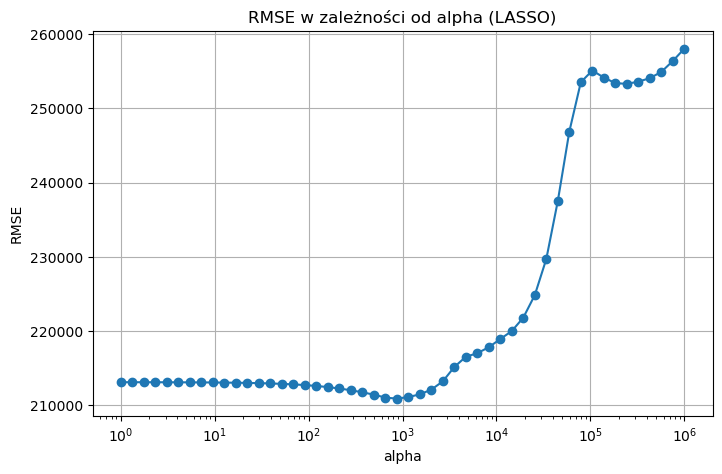

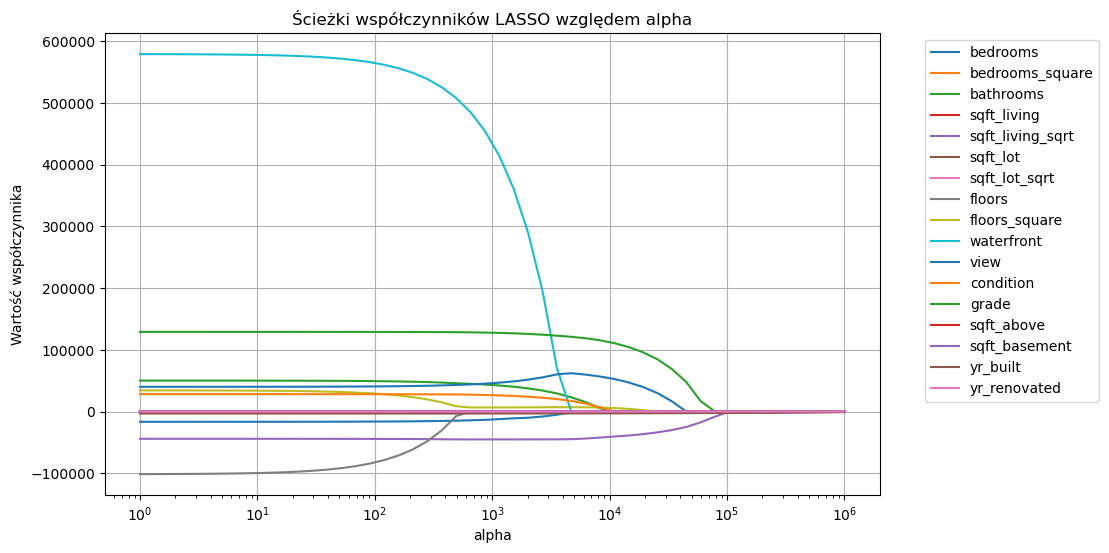

In [28]:
LassoX_train, LassoX_test, LassoY_train, LassoY_test = train_test_split(
    sales[all_features], sales['price'], test_size=0.2, random_state=0
)

alphas = np.logspace(0, 6, 50)
mean_rmse = []
coef_dict = {}

for a in alphas:
    model = linear_model.Lasso(alpha=a, max_iter=10000, random_state=0)
    neg_mse = cross_val_score(model, LassoX_train, LassoY_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.mean(np.sqrt(-neg_mse))
    mean_rmse.append(rmse)
    model.fit(LassoX_train, LassoY_train)
    coef_dict[a] = model.coef_.copy()

best_idx = int(np.argmin(mean_rmse))
best_alpha = alphas[best_idx]
best_coef = coef_dict[best_alpha]

print(f'Optymalne alpha: {best_alpha}')
print('Współczynniki przy dobranym alpha:')
for feat, c in zip(all_features, best_coef):
    print(f'{feat}: {c}')

num_nonzero = int(np.sum(best_coef != 0))
num_zero = int(np.sum(best_coef == 0))
print(f'Liczba cech z niezerowym współczynnikiem: {num_nonzero}')
print(f'Liczba cech wyzerowanych przez LASSO: {num_zero}')

plt.figure(figsize=(8,5))
plt.plot(alphas, mean_rmse, marker='o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('RMSE w zależności od alpha (LASSO)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for i, feat in enumerate(all_features):
    vals = [coef_dict[a][i] for a in alphas]
    plt.plot(alphas, vals, label=feat)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Wartość współczynnika')
plt.title('Ścieżki współczynników LASSO względem alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

wyniki:

Optymalne alpha: 868.511373751352

Współczynniki przy dobranym alpha:

bedrooms: -13391.162869813877

bedrooms_square: 189.91531120886762

bathrooms: 43789.272422153

sqft_living: 311.014874421978

sqft_living_sqrt: -45176.558151706224

sqft_lot: 0.6901462627939163

sqft_lot_sqrt: -669.3615775295615

floors: -0.0

floors_square: 6607.288091166248

waterfront: 454683.6239171381

view: 45256.89763557474

condition: 26892.730857823834

grade: 128017.70029688116

sqft_above: 309.8230093312282

sqft_basement: 316.6137164745418

yr_built: -3129.0675341515716

yr_renovated: 20.089345654617816

Liczba cech z niezerowym współczynnikiem: 16

Liczba cech wyzerowanych przez LASSO: 1


**Pytania:**
1. Jaką wartość parametru $\lambda$ wybrałbyś/wybrałabyś dla naszego modelu ?
2. Które z cech, dla ustalonej wartości parametru $\lambda$ wchodzą w skład modelu - podaj w kolejności od najbardziej znaczących cech ?

In [30]:
coef_pairs = list(zip(all_features, best_coef))
coef_sorted = sorted(coef_pairs, key=lambda x: abs(x[1]), reverse=True)

print("\nCechy uporządkowane wg znaczenia:")
for name, val in coef_sorted:
    print(f"{name}: {val}")



Cechy uporządkowane wg znaczenia:
waterfront: 454683.6239171381
grade: 128017.70029688116
view: 45256.89763557474
sqft_living_sqrt: -45176.558151706224
bathrooms: 43789.272422153
condition: 26892.730857823834
bedrooms: -13391.162869813877
floors_square: 6607.288091166248
yr_built: -3129.0675341515716
sqft_lot_sqrt: -669.3615775295615
sqft_basement: 316.6137164745418
sqft_living: 311.014874421978
sqft_above: 309.8230093312282
bedrooms_square: 189.91531120886762
yr_renovated: 20.089345654617816
sqft_lot: 0.6901462627939163
floors: -0.0


1. Do naszego modelu wybrałbym wartość ok 870

2. Wyżej - cechy uporządkowane wg znaczenia. Tylko jedna cecha nie wchodzi w skłąd modelu - floors (wynosi 0)